In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_log_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error


%matplotlib inline

sns.set(style="darkgrid")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
sns.set(rc={'figure.figsize':(14, 10)})


In [6]:
trades_bit = pd.read_csv('/content/drive/MyDrive/CMF HFT/trades.csv')

trades_eth = pd.read_csv('/content/drive/MyDrive/CMF HFT/trades-eth.csv')

lobs_bit = pd.read_csv('/content/drive/MyDrive/CMF HFT/lobs.csv')

lobs_eth = pd.read_csv('/content/drive/MyDrive/CMF HFT/lobs-eth.csv')


### 1. Поанализируем данные с помощью графиков 

In [7]:
print(f'Trades bit shape {trades_bit.shape[0]}')
print(f'Trades eth shape {trades_eth.shape[0]}')
print(f'Lobs bit shape {lobs_bit.shape[0]}')
print(f'Lobs eth shape {lobs_eth.shape[0]}')

Trades bit shape 5727714
Trades eth shape 4873803
Lobs bit shape 2541356
Lobs eth shape 2539699


In [8]:
trades_bit

,receive_ts,exchange_ts,aggro_side,price,size
0,1655942402624789714,1655942402623000000,BID,19977.5,0.001
1,1655942405293556247,1655942405292000000,BID,19977.5,0.041
2,1655942405293628020,1655942405292000000,BID,19977.5,0.036
3,1655942405293832021,1655942405292000000,BID,19977.5,0.001
4,1655942405293929517,1655942405292000000,BID,19977.5,0.001
...,...,...,...,...,...
5727709,1656028781074283766,1656028781073000000,BID,21089.1,0.001
5727710,1656028781105532654,1656028781104000000,ASK,21089.0,0.059
5727711,1656028781335919353,1656028781335000000,ASK,21089.0,0.137
5727712,1656028781343654663,1656028781342000000,BID,21089.1,0.030


In [9]:
lobs_bit

,receive_ts,exchange_ts,btcusdt:Binance:LinearPerpetual_ask_price_0,btcusdt:Binance:LinearPerpetual_ask_vol_0,btcusdt:Binance:LinearPerpetual_bid_price_0,btcusdt:Binance:LinearPerpetual_bid_vol_0,btcusdt:Binance:LinearPerpetual_ask_price_1,btcusdt:Binance:LinearPerpetual_ask_vol_1,btcusdt:Binance:LinearPerpetual_bid_price_1,btcusdt:Binance:LinearPerpetual_bid_vol_1,...,btcusdt:Binance:LinearPerpetual_bid_price_7,btcusdt:Binance:LinearPerpetual_bid_vol_7,btcusdt:Binance:LinearPerpetual_ask_price_8,btcusdt:Binance:LinearPerpetual_ask_vol_8,btcusdt:Binance:LinearPerpetual_bid_price_8,btcusdt:Binance:LinearPerpetual_bid_vol_8,btcusdt:Binance:LinearPerpetual_ask_price_9,btcusdt:Binance:LinearPerpetual_ask_vol_9,btcusdt:Binance:LinearPerpetual_bid_price_9,btcusdt:Binance:LinearPerpetual_bid_vol_9
0,1655942402250125991,1655942402249000000,19977.5,0.079,19977.4,12.381,19977.8,0.003,19976.7,0.066,...,19975.7,4.455,19980.1,0.01,19975.6,1.529,19980.2,0.010,19975.4,1.641
1,1655942402657844605,1655942402655000000,19977.5,0.078,19977.4,12.381,19977.8,0.003,19977.3,0.126,...,19975.9,0.246,19980.1,0.01,19975.8,0.686,19980.2,0.010,19975.7,4.455
2,1655942403346968722,1655942403346000000,19977.5,0.079,19977.4,12.381,19977.8,0.003,19977.3,0.126,...,19975.9,0.246,19980.1,0.01,19975.8,0.686,19980.2,0.010,19975.7,4.455
3,1655942404080791047,1655942404080000000,19977.5,0.079,19977.4,12.381,19977.8,0.003,19977.3,0.126,...,19975.9,0.246,19980.1,0.01,19975.8,0.686,19980.2,0.010,19975.7,4.455
4,1655942404452706766,1655942404452000000,19977.5,0.079,19977.4,12.381,19977.8,0.003,19977.3,0.126,...,19975.9,0.246,19980.1,0.01,19975.8,0.686,19980.2,0.010,19975.7,4.455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541351,1656028781390653694,1656028781390000000,21089.1,0.730,21089.0,7.845,21089.3,0.001,21088.9,2.800,...,21087.4,0.024,21092.5,0.55,21087.1,0.232,21092.6,0.001,21087.0,2.484
2541352,1656028781423672729,1656028781423000000,21089.1,0.730,21089.0,7.845,21089.3,0.001,21088.9,2.800,...,21087.4,0.024,21092.4,0.83,21087.1,0.232,21092.5,0.550,21087.0,2.484
2541353,1656028781457683317,1656028781457000000,21089.1,0.736,21089.0,7.845,21089.3,0.001,21088.9,2.800,...,21087.4,0.024,21092.4,0.83,21087.1,0.232,21092.5,0.550,21087.0,2.484
2541354,1656028781492806433,1656028781492000000,21089.1,0.736,21089.0,7.845,21089.3,0.001,21088.9,2.800,...,21087.4,0.024,21092.4,0.83,21087.1,0.232,21092.5,0.550,21087.0,2.484


In [10]:
lobs_bit['receive_ts'] = pd.to_datetime(lobs_bit['receive_ts'])
lobs_bit[' exchange_ts'] = pd.to_datetime(lobs_bit[' exchange_ts'])

trades_bit['receive_ts'] = pd.to_datetime(trades_bit['receive_ts'])
trades_bit['exchange_ts'] = pd.to_datetime(trades_bit['exchange_ts'])

In [11]:
lobs_eth['receive_ts'] = pd.to_datetime(lobs_eth['receive_ts'])
lobs_eth[' exchange_ts'] = pd.to_datetime(lobs_eth[' exchange_ts'])

trades_eth['receive_ts'] = pd.to_datetime(trades_eth['receive_ts'])
trades_eth['exchange_ts'] = pd.to_datetime(trades_eth['exchange_ts'])

In [12]:
trades_bit = trades_bit.set_index('receive_ts', drop=False)
trades_eth = trades_eth.set_index('receive_ts', drop=False)

lobs_bit = lobs_bit.set_index('receive_ts', drop=False)
lobs_eth = lobs_eth.set_index('receive_ts', drop=False)

In [22]:
lobs_bit.columns = [i.replace('btcusdt:Binance:LinearPerpetual_', '') for i in lobs_bit.columns]

lobs_eth.columns = [i.replace('ethusdt:Binance:LinearPerpetual_', '') for i in lobs_eth.columns]

In [14]:
print(trades_bit.isna().sum().sum())
print(trades_eth.isna().sum().sum())
print(lobs_bit.isna().sum().sum())
print(lobs_eth.isna().sum().sum())

0
0
0
0


In [23]:
lobs_bit.head(2)

,receive_ts,exchange_ts,ask_price_0,ask_vol_0,bid_price_0,bid_vol_0,ask_price_1,ask_vol_1,bid_price_1,bid_vol_1,...,bid_price_7,bid_vol_7,ask_price_8,ask_vol_8,bid_price_8,bid_vol_8,ask_price_9,ask_vol_9,bid_price_9,bid_vol_9
receive_ts,,,,,,,,,,,,,,,,,,,,,
2022-06-23 00:00:02.250125991,2022-06-23 00:00:02.250125991,2022-06-23 00:00:02.249,19977.5,0.079,19977.4,12.381,19977.8,0.003,19976.7,0.066,...,19975.7,4.455,19980.1,0.01,19975.6,1.529,19980.2,0.01,19975.4,1.641
2022-06-23 00:00:02.657844605,2022-06-23 00:00:02.657844605,2022-06-23 00:00:02.655,19977.5,0.078,19977.4,12.381,19977.8,0.003,19977.3,0.126,...,19975.9,0.246,19980.1,0.01,19975.8,0.686,19980.2,0.01,19975.7,4.455


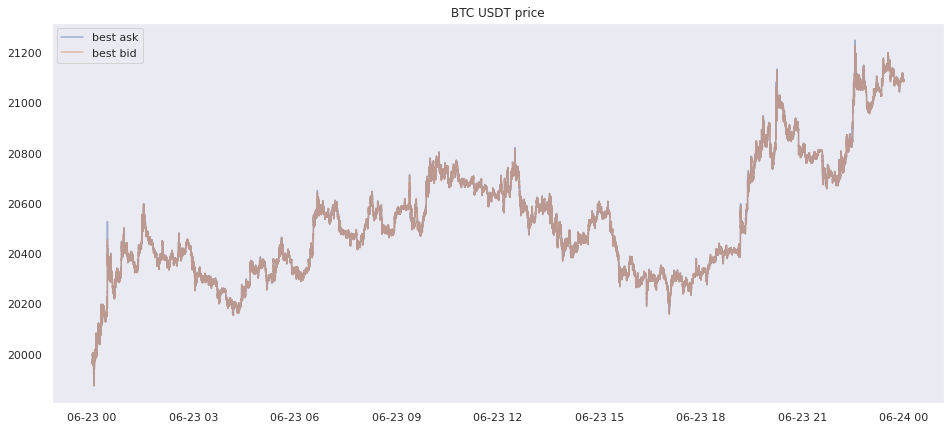

In [24]:
plt.figure(figsize=(16, 7))
plt.plot(lobs_bit['ask_price_0'], alpha=0.5, label='best ask')
plt.plot(lobs_bit['bid_price_0'], alpha=0.5, label='best bid')
plt.grid()
plt.legend()
plt.title('BTC USDT price')
plt.show()

In [25]:
lobs_eth.head()

,receive_ts,exchange_ts,ask_price_0,ask_vol_0,bid_price_0,bid_vol_0,ask_price_1,ask_vol_1,bid_price_1,bid_vol_1,...,bid_price_7,bid_vol_7,ask_price_8,ask_vol_8,bid_price_8,bid_vol_8,ask_price_9,ask_vol_9,bid_price_9,bid_vol_9
receive_ts,,,,,,,,,,,,,,,,,,,,,
2022-06-23 00:00:02.250395360,2022-06-23 00:00:02.250395360,2022-06-23 00:00:02.249,1049.45,1.046,1049.44,0.782,1049.46,2.229,1049.43,5.0,...,1049.31,7.495,1049.53,2.229,1049.3,1.452,1049.54,27.741,1049.29,2.387
2022-06-23 00:00:02.656012600,2022-06-23 00:00:02.656012600,2022-06-23 00:00:02.655,1049.45,0.314,1049.44,19.860,1049.46,2.243,1049.43,5.0,...,1049.31,7.495,1049.53,2.229,1049.3,1.452,1049.54,27.741,1049.29,2.387
2022-06-23 00:00:03.348658915,2022-06-23 00:00:03.348658915,2022-06-23 00:00:03.348,1049.45,0.314,1049.44,19.860,1049.46,2.243,1049.43,5.0,...,1049.31,7.495,1049.53,2.229,1049.3,1.452,1049.54,27.741,1049.29,2.387
2022-06-23 00:00:04.080743828,2022-06-23 00:00:04.080743828,2022-06-23 00:00:04.080,1049.45,0.314,1049.44,19.860,1049.46,2.243,1049.43,5.0,...,1049.31,7.495,1049.53,2.229,1049.3,1.452,1049.54,27.741,1049.29,2.387
2022-06-23 00:00:04.151722232,2022-06-23 00:00:04.151722232,2022-06-23 00:00:04.151,1049.45,0.314,1049.44,19.860,1049.46,2.243,1049.43,5.0,...,1049.31,7.495,1049.53,2.229,1049.3,1.452,1049.54,27.741,1049.29,2.387


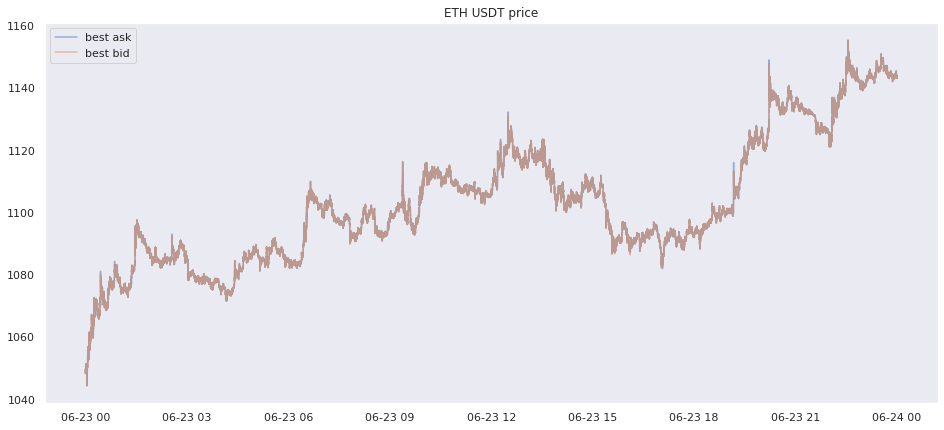

In [26]:
plt.figure(figsize=(16, 7))
plt.plot(lobs_eth['ask_price_0'], alpha=0.5, label='best ask')
plt.plot(lobs_eth['bid_price_0'], alpha=0.5, label='best bid')
plt.grid()
plt.legend()
plt.title('ETH USDT price')
plt.show()

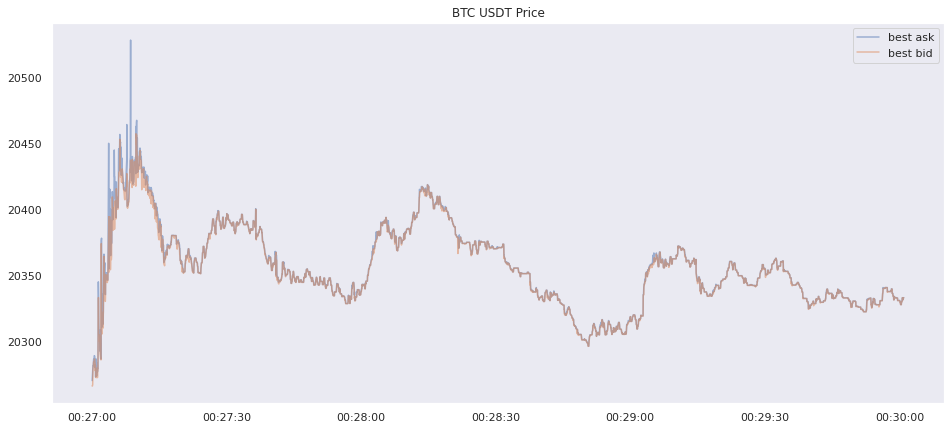

In [27]:
start_time = '2022-06-23 00:27:00'
end_time = '2022-06-23 00:30:00'
sample_ask = lobs_bit['ask_price_0'].loc[start_time:end_time]
sample_bid = lobs_bit['bid_price_0'].loc[start_time:end_time]

plt.figure(figsize=(16, 7))
plt.plot(sample_ask, alpha=0.5, label='best ask')
plt.plot(sample_bid, alpha=0.5, label='best bid')
plt.grid()
plt.legend()
plt.title('BTC USDT Price')
plt.show()

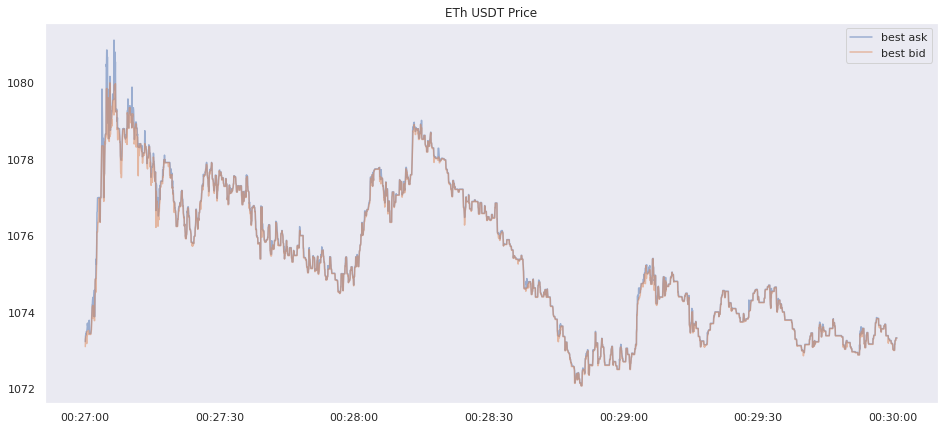

In [28]:
start_time = '2022-06-23 00:27:00'
end_time = '2022-06-23 00:30:00'
sample_ask = lobs_eth['ask_price_0'].loc[start_time:end_time]
sample_bid = lobs_eth['bid_price_0'].loc[start_time:end_time]

plt.figure(figsize=(16, 7))
plt.plot(sample_ask, alpha=0.5, label='best ask')
plt.plot(sample_bid, alpha=0.5, label='best bid')
plt.grid()
plt.legend()
plt.title('ETh USDT Price')
plt.show()

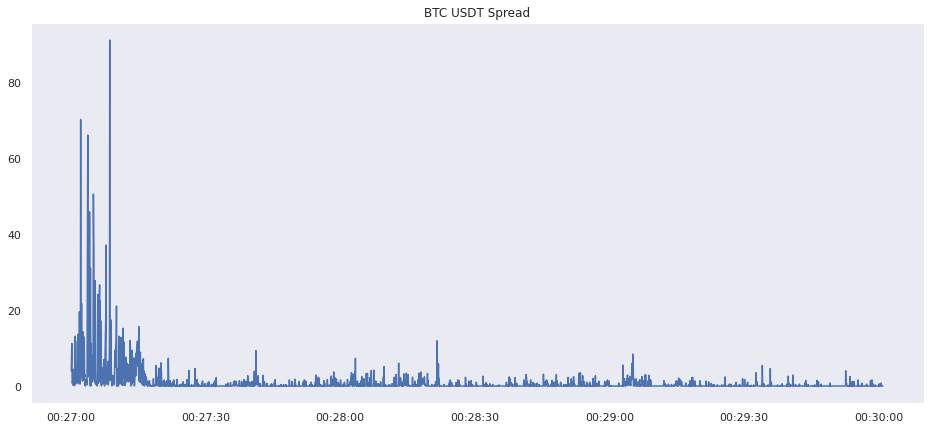

In [29]:
sample_ask = lobs_bit['ask_price_0'].loc[start_time:end_time]
sample_bid = lobs_bit['bid_price_0'].loc[start_time:end_time]

plt.figure(figsize=(16, 7))
plt.plot(sample_ask - sample_bid)
plt.grid()
plt.title('BTC USDT Spread')
plt.show()

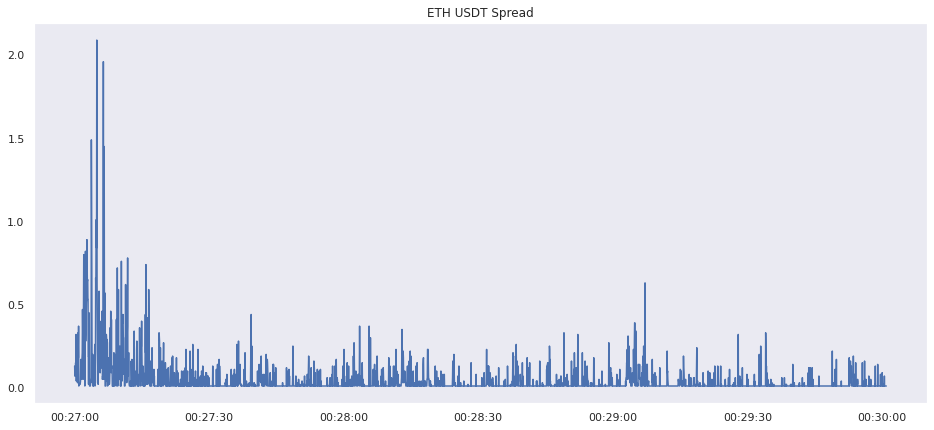

In [30]:
sample_ask = lobs_eth['ask_price_0'].loc[start_time:end_time]
sample_bid = lobs_eth['bid_price_0'].loc[start_time:end_time]

plt.figure(figsize=(16, 7))
plt.plot(sample_ask - sample_bid)
plt.grid()
plt.title('ETH USDT Spread')
plt.show()

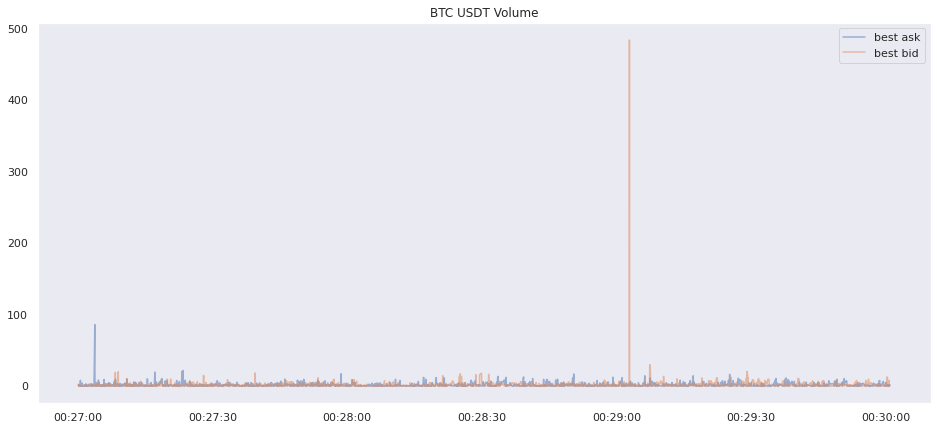

In [31]:
sample_ask = lobs_bit['ask_vol_0'].loc[start_time:end_time]
sample_bid = lobs_bit['bid_vol_0'].loc[start_time:end_time]

plt.figure(figsize=(16, 7))
plt.plot(sample_ask, alpha=0.5, label='best ask')
plt.plot(sample_bid, alpha=0.5, label='best bid')
plt.grid()
plt.legend()
plt.title('BTC USDT Volume')
plt.show()

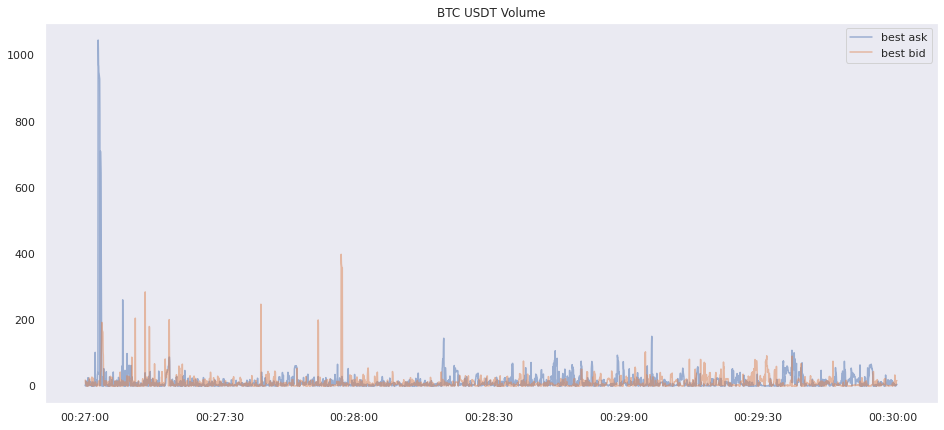

In [32]:
sample_ask = lobs_eth['ask_vol_0'].loc[start_time:end_time]
sample_bid = lobs_eth['bid_vol_0'].loc[start_time:end_time]

plt.figure(figsize=(16, 7))
plt.plot(sample_ask, alpha=0.5, label='best ask')
plt.plot(sample_bid, alpha=0.5, label='best bid')
plt.grid()
plt.legend()
plt.title('BTC USDT Volume')
plt.show()

In [33]:
k = 10
lobs_bit['ask_vol_sum'] = lobs_bit[[f'ask_vol_{i}' for i in range(k)]].sum(axis=1)
lobs_bit['bid_vol_sum'] = lobs_bit[[f'bid_vol_{i}' for i in range(k)]].sum(axis=1)

In [34]:
lobs_eth['ask_vol_sum'] = lobs_eth[[f'ask_vol_{i}' for i in range(k)]].sum(axis=1)
lobs_eth['bid_vol_sum'] = lobs_eth[[f'bid_vol_{i}' for i in range(k)]].sum(axis=1)

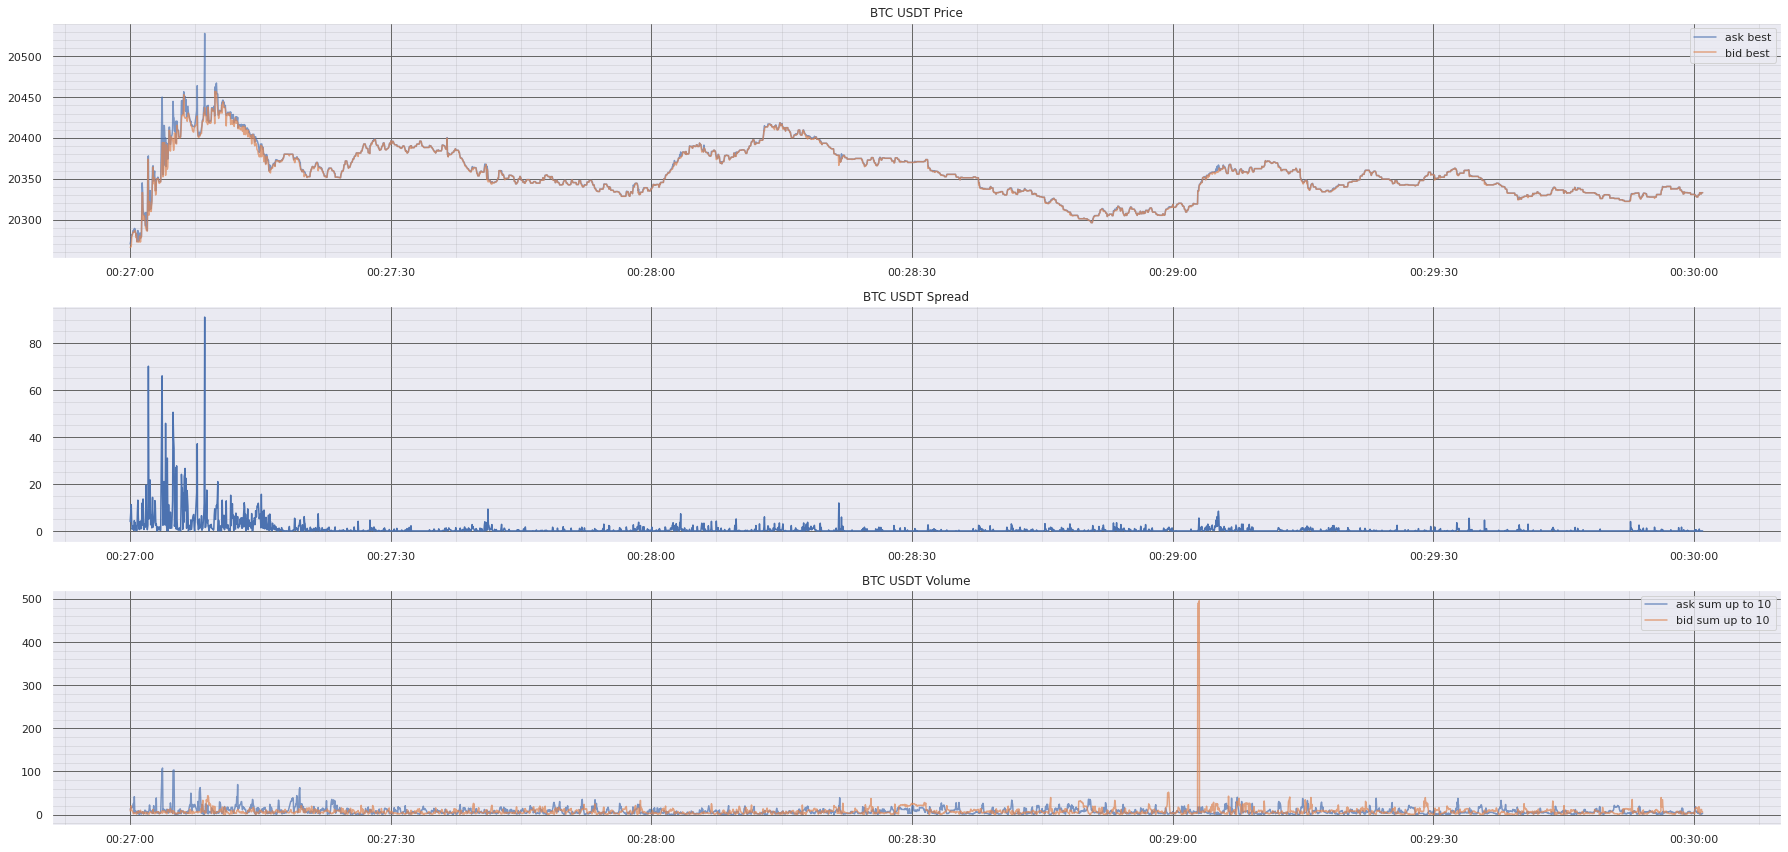

In [35]:
sample_df= lobs_bit.loc[start_time:end_time]


n_plots = 3
plt.figure(figsize=(25, 12))


plt.subplot(n_plots, 1, 1)
plt.plot(sample_df['ask_price_0'], alpha=0.7, label='ask best')
plt.plot(sample_df['bid_price_0'], alpha=0.7, label='bid best')
plt.legend()
plt.title('BTC USDT Price')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)


plt.subplot(n_plots, 1, 2)
plt.plot(sample_df['ask_price_0'] - sample_df['bid_price_0'])
plt.title('BTC USDT Spread')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)


plt.subplot(n_plots, 1, 3)
plt.plot(sample_df['ask_vol_sum'], alpha=0.7, label=f'ask sum up to {k}')
plt.plot(sample_df['bid_vol_sum'], alpha=0.7, label=f'bid sum up to {k}')
plt.legend()
plt.title('BTC USDT Volume')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)


plt.tight_layout()
plt.show()

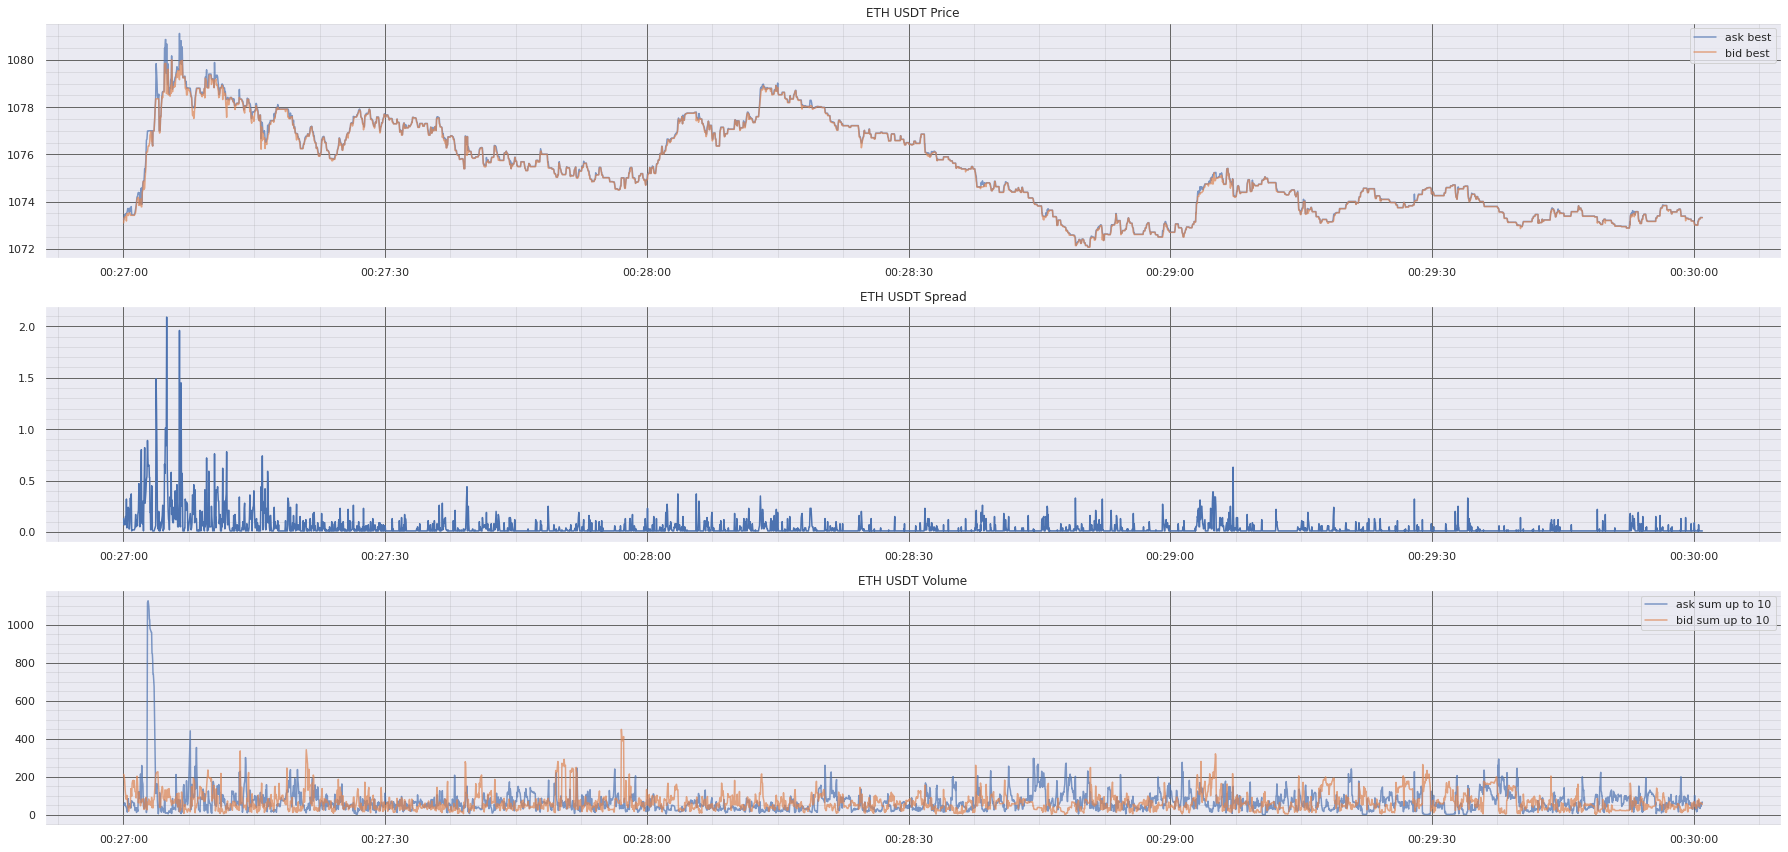

In [36]:
sample_df= lobs_eth.loc[start_time:end_time]


n_plots = 3
plt.figure(figsize=(25, 12))


plt.subplot(n_plots, 1, 1)
plt.plot(sample_df['ask_price_0'], alpha=0.7, label='ask best')
plt.plot(sample_df['bid_price_0'], alpha=0.7, label='bid best')
plt.legend()
plt.title('ETH USDT Price')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)


plt.subplot(n_plots, 1, 2)
plt.plot(sample_df['ask_price_0'] - sample_df['bid_price_0'])
plt.title('ETH USDT Spread')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)


plt.subplot(n_plots, 1, 3)
plt.plot(sample_df['ask_vol_sum'], alpha=0.7, label=f'ask sum up to {k}')
plt.plot(sample_df['bid_vol_sum'], alpha=0.7, label=f'bid sum up to {k}')
plt.legend()
plt.title('ETH USDT Volume')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)


plt.tight_layout()
plt.show()

In [37]:
ping_bit = (lobs_bit['receive_ts'] - lobs_bit[' exchange_ts']).apply(lambda x: x.total_seconds()) * 1000

ping_eth = (lobs_eth['receive_ts'] - lobs_eth[' exchange_ts']).apply(lambda x: x.total_seconds()) * 1000

In [38]:
ping_bit.describe()

count    2.541356e+06
mean     1.616722e+00
std      1.000314e+01
min      4.940000e-01
25%      7.590000e-01
50%      8.910000e-01
75%      1.115000e+00
max      7.573740e+02
dtype: float64

In [39]:
ping_eth.describe()

count    2.539699e+06
mean     1.456474e+00
std      1.000848e+01
min      3.080000e-01
25%      6.160000e-01
50%      7.540000e-01
75%      9.770000e-01
max      7.784340e+02
dtype: float64

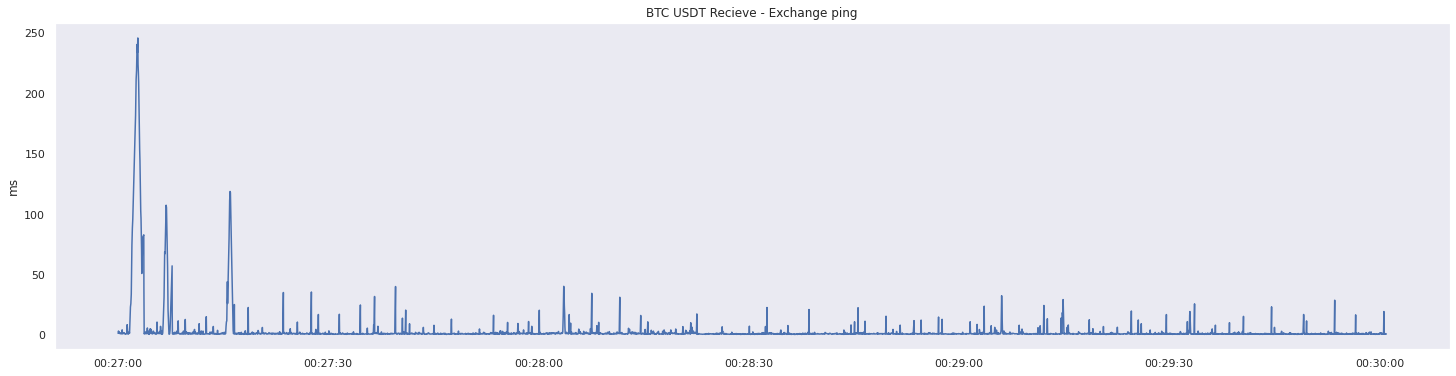

In [40]:
sample_ping_bit = ping_bit.loc[start_time:end_time]

plt.figure(figsize=(25, 6))
plt.plot(sample_ping_bit)
plt.grid()
plt.title('BTC USDT Recieve - Exchange ping')
plt.ylabel('ms')
plt.show()

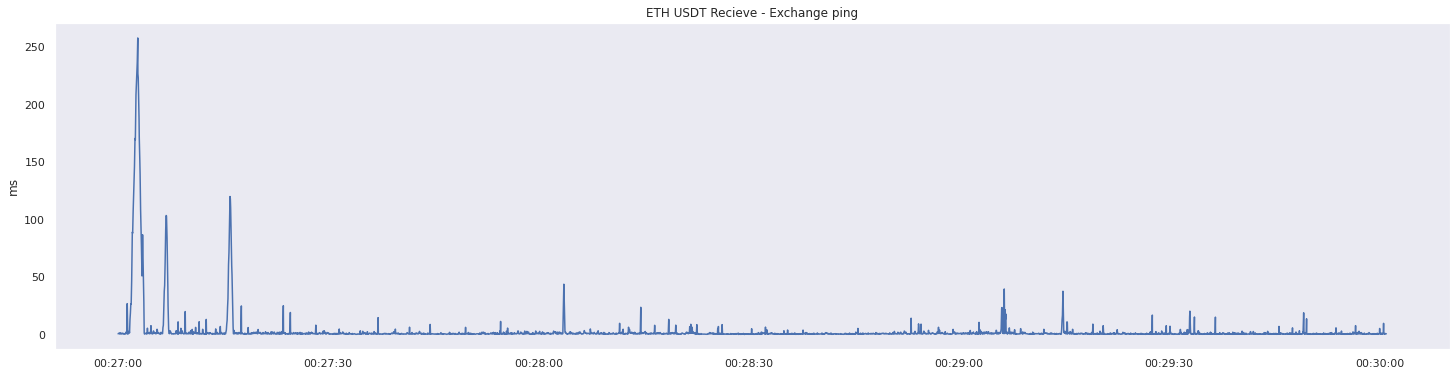

In [41]:
sample_ping_eth = ping_eth.loc[start_time:end_time]

plt.figure(figsize=(25, 6))
plt.plot(sample_ping_eth)
plt.grid()
plt.title('ETH USDT Recieve - Exchange ping')
plt.ylabel('ms')
plt.show()

In [42]:
local_tick = lobs_bit['receive_ts'].diff().apply(lambda x: x.total_seconds()) * 1000

In [43]:
exch_tick = lobs_bit[' exchange_ts'].diff().apply(lambda x: x.total_seconds()) * 1000

In [44]:
pd.concat([local_tick.describe(), exch_tick.describe()], axis=1)

,receive_ts,exchange_ts
count,2.541355e+06,2.541355e+06
mean,3.398896e+01,3.398946e+01
std,5.635235e+00,5.093903e+00
min,2.900000e-02,4.000000e+00
25%,3.209800e+01,3.200000e+01
50%,3.301200e+01,3.300000e+01
75%,3.407200e+01,3.400000e+01
max,2.480420e+03,2.481000e+03


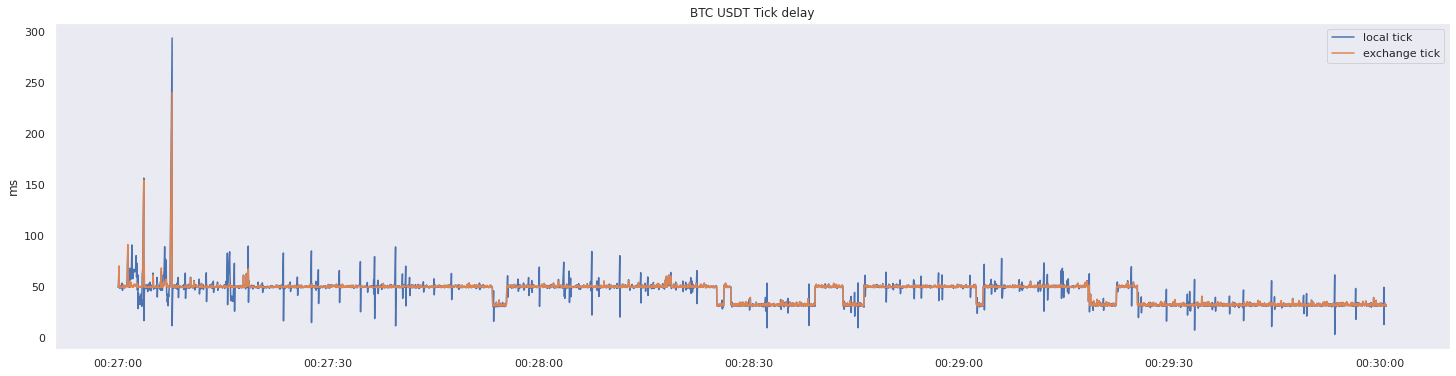

In [45]:
sample_local_tick = local_tick.loc[start_time:end_time]
sample_exch_tick = exch_tick.loc[start_time:end_time]

plt.figure(figsize=(25, 6))
plt.plot(sample_local_tick, label='local tick')
plt.plot(sample_exch_tick, label='exchange tick')
plt.grid()
plt.legend()
plt.title('BTC USDT Tick delay')
plt.ylabel('ms')
plt.show()

### 2. Теперь поанализируем датафрейм с трейдами.

In [46]:
size_bit = trades_bit.groupby(['exchange_ts']).agg({'size':'sum'})
size_eth = trades_eth.groupby(['exchange_ts']).agg({'size':'sum'})

In [47]:
size_bit.head()

,size
exchange_ts,
2022-06-23 00:00:02.623,0.001
2022-06-23 00:00:05.292,0.086
2022-06-23 00:00:08.890,0.020
2022-06-23 00:00:09.193,0.383
2022-06-23 00:00:09.198,0.199


In [48]:
eth_var_hs_95 = size_eth['size'].quantile(0.95)
eth_var_hs_05 = size_eth['size'].quantile(0.05)
bit_var_hs_95 = size_bit['size'].quantile(0.95)
bit_var_hs_05 = size_bit['size'].quantile(0.05)

print(eth_var_hs_95)
print(eth_var_hs_05)
print(bit_var_hs_95)
print(bit_var_hs_95)

15.075
0.005
1.467
1.467


In [49]:
eth_quantile_size = size_eth[size_eth['size']<eth_var_hs_95]
bit_quantile_size = size_bit[size_bit['size']<bit_var_hs_95]

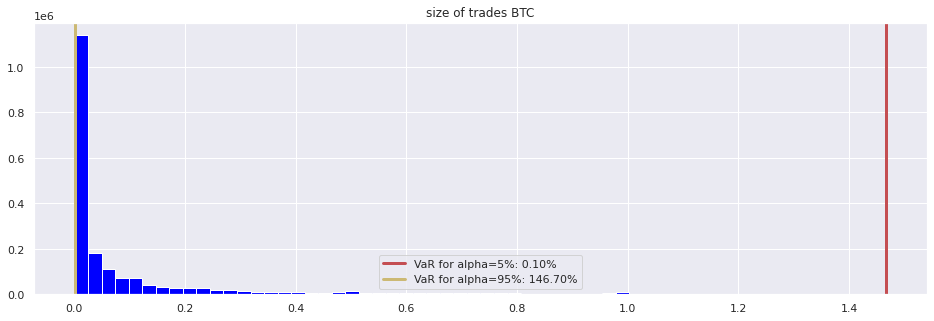

In [50]:
fig = plt.figure(figsize=(16, 5))
plt.axvline(bit_var_hs_95, linewidth=3, color="r")
plt.axvline(bit_var_hs_05, linewidth=3, color="y")
plt.hist(bit_quantile_size['size'], bins=60, color='blue')
plt.title('size of trades BTC')
plt.legend(['VaR for alpha=5%: {:.2f}%'.format(100*bit_var_hs_05),
            'VaR for alpha=95%: {:.2f}%'.format(100*bit_var_hs_95)])
plt.show()

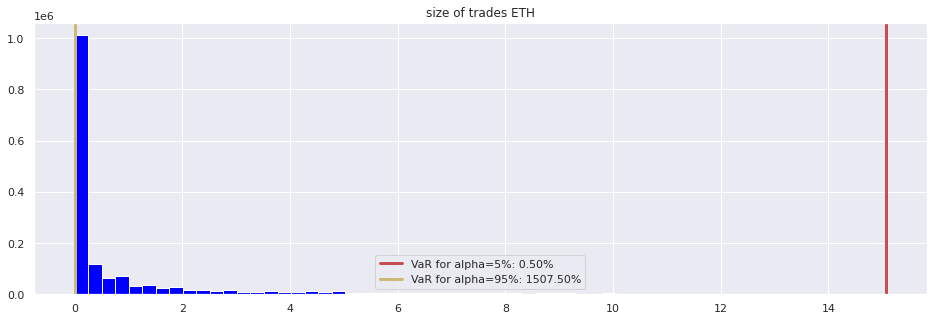

In [51]:
fig = plt.figure(figsize=(16, 5))
plt.axvline(eth_var_hs_95, linewidth=3, color="r")
plt.axvline(eth_var_hs_05, linewidth=3, color="y")
plt.hist(eth_quantile_size['size'], bins=60, color='blue')
plt.title('size of trades ETH')
plt.legend(['VaR for alpha=5%: {:.2f}%'.format(100*eth_var_hs_05),
            'VaR for alpha=95%: {:.2f}%'.format(100*eth_var_hs_95)])
plt.show()

In [52]:
for i in range(0, 0):
  print(1)

Тут хотел красиво отрисовать графики через цикл. Что-то пошло не так. Логика вроде полностью верная по отрисовке. Просто что-то не хватило времени разобраться как это аккуратно сделать. 

""


ValueError: ignored

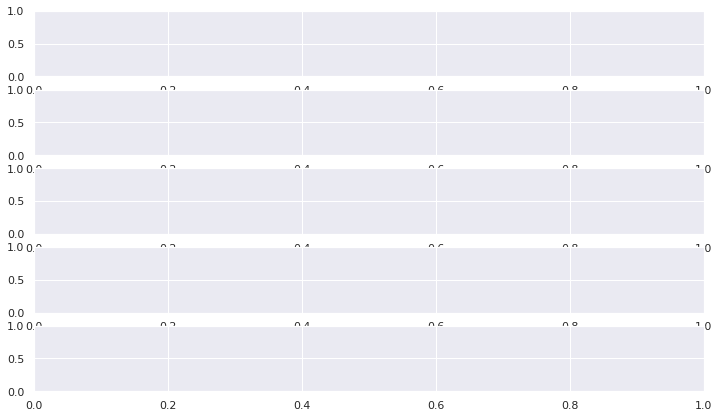

In [82]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 7))
num_bins = 100

for i in range(0, 5):
  bit_bid = pd.DataFrame()
  bit_ask = pd.DataFrame()
  for j in range(0, i):

    bit_bid = pd.concat([bit_bid, lobs_bit[f'bid_vol_{j}']])
    bit_ask = pd.concat([bit_ask, lobs_bit[f'ask_vol_{j}']])

  display(bit_bid)
  bid_lim = bit_bid.quantile(0.95)
  ask_lim = bit_ask.quantile(0.95)


  axes[i + j].hist(lobs_bit[lobs_bit[f'bid_vol_{j}'] < bid_lim][f'bid_vol_{j}'], num_bins,
                           density = 1, 
                           color ='green', 
                           alpha = 0.7)
  
  axes[i + j + 1].hist(lobs_bit[lobs_bit[f'ask_vol_{j}']< ask_lim][f'ask_vol_{j}'], num_bins,
                           density = 1, 
                           color ='vlue', 
                           alpha = 0.7)


fig.tight_layout()
plt.show()

In [95]:
mean_eth_size= size_eth['size'].mean()
std_eth_size= size_eth['size'].std()
median_eth_size= size_eth['size'].quantile(0.5)

mean_bit_size= size_bit['size'].mean()
std_bit_size= size_bit['size'].std()
median_bit_size= size_bit['size'].quantile(0.5)

In [96]:
print(f'metrics for Bit: {mean_bit_size,std_bit_size,median_bit_size}')

print(f'metrics for Eth: {mean_eth_size,std_eth_size,median_eth_size }')

metrics for Bit: (0.33379208588077963, 1.5567680001558255, 0.018000000000000002)
metrics for Eth: (3.4072797525612946, 16.139470963013235, 0.087)


In [56]:
trades_bit.head(5)

,receive_ts,exchange_ts,aggro_side,price,size
receive_ts,,,,,
2022-06-23 00:00:02.624789714,2022-06-23 00:00:02.624789714,2022-06-23 00:00:02.623,BID,19977.5,0.001
2022-06-23 00:00:05.293556247,2022-06-23 00:00:05.293556247,2022-06-23 00:00:05.292,BID,19977.5,0.041
2022-06-23 00:00:05.293628020,2022-06-23 00:00:05.293628020,2022-06-23 00:00:05.292,BID,19977.5,0.036
2022-06-23 00:00:05.293832021,2022-06-23 00:00:05.293832021,2022-06-23 00:00:05.292,BID,19977.5,0.001
2022-06-23 00:00:05.293929517,2022-06-23 00:00:05.293929517,2022-06-23 00:00:05.292,BID,19977.5,0.001


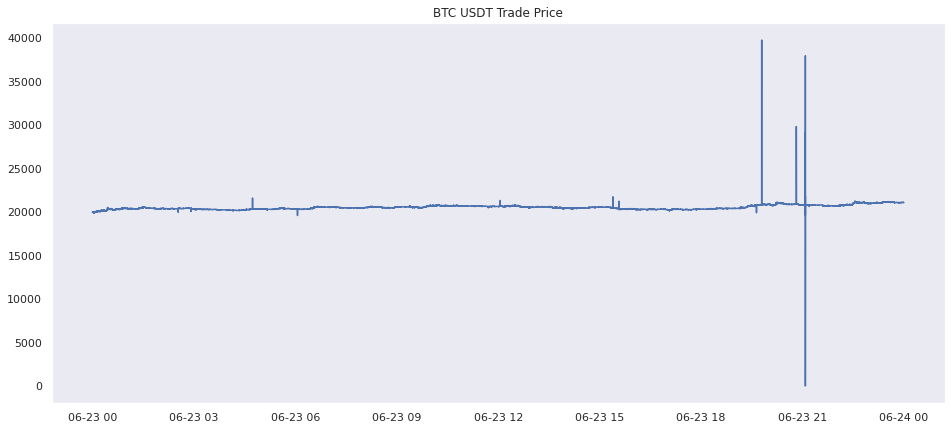

In [57]:
plt.figure(figsize=(16, 7))
plt.plot(trades_bit['price'])
plt.grid()
plt.title('BTC USDT Trade Price')
plt.show()

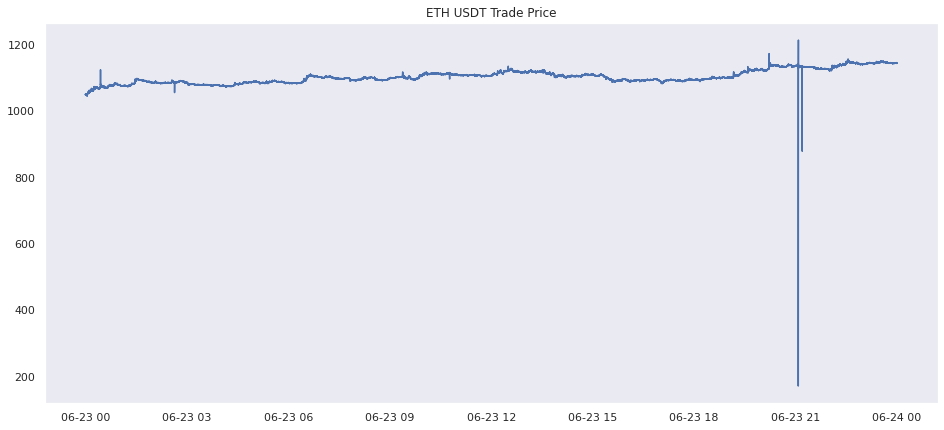

In [59]:
plt.figure(figsize=(16, 7))
plt.plot(trades_eth['price'])
plt.grid()
plt.title('ETH USDT Trade Price')
plt.show()

Попробуем задетектить выбросы. Посмотрим на модуль разницы соседних цен. Надо будет понять какие из этих изменений аномальные

In [60]:
trades_bit['price'].diff().abs().sort_values(ascending=False).head(100)

receive_ts
2022-06-23 21:04:54.215230609    20785.70
2022-06-23 21:04:54.203729877    20785.60
2022-06-23 19:47:25.857454402    18913.08
2022-06-23 19:47:25.853109188    18913.08
2022-06-23 21:04:52.439506062    17170.71
                                   ...   
2022-06-23 21:04:56.586367643       98.08
2022-06-23 00:27:02.082393530       97.30
2022-06-23 00:27:02.082767486       95.30
2022-06-23 00:27:02.082875111       95.30
2022-06-23 21:04:58.101591749       94.50
Name: price, Length: 100, dtype: float64

Изменения в 20тыс точно являются аномальными, про остальные точки пока ничего сказать не можем. 

1. Удобнее смотреть на мид прайс. Для этого сгруппируем данные по времени трейдов(могут быть трейды в одно время), затем посчитаем мид прайс для каждого времени. Далее возьмем какое-то время и будем смотреть на $t + \Delta, t - \Delta$

Дельту выберем какую-то маленькую 

In [61]:
agg_trades_bit = trades_bit.groupby(by='exchange_ts').agg({'receive_ts': 'last', 'price': ['max', 'min'], 'size': 'sum', 'aggro_side': ['last', 'count']})

agg_trades_eth = trades_eth.groupby(by='exchange_ts').agg({'receive_ts': 'last', 'price': ['max', 'min'], 'size': 'sum', 'aggro_side': ['last', 'count']})

In [63]:
agg_trades_bit.head(5)

receive_ts    price           \
                                                 last      max      min   
exchange_ts                                                               
2022-06-23 00:00:02.623 2022-06-23 00:00:02.624789714  19977.5  19977.5   
2022-06-23 00:00:05.292 2022-06-23 00:00:05.294206928  19978.0  19977.5   
2022-06-23 00:00:08.890 2022-06-23 00:00:08.891268324  19977.9  19977.9   
2022-06-23 00:00:09.193 2022-06-23 00:00:09.197580020  19978.0  19977.9   
2022-06-23 00:00:09.198 2022-06-23 00:00:09.199451160  19978.0  19978.0   

                          size aggro_side        
                           sum       last count  
exchange_ts                                      
2022-06-23 00:00:02.623  0.001        BID     1  
2022-06-23 00:00:05.292  0.086        BID     7  
2022-06-23 00:00:08.890  0.020        ASK     1  
2022-06-23 00:00:09.193  0.383        ASK     6  
2022-06-23 00:00:09.198  0.199        BID     1

Подправим немного колонки

In [65]:
agg_trades_bit.columns = ['_'.join(i) for i in agg_trades_bit]
agg_trades_eth.columns = ['_'.join(i) for i in agg_trades_eth]

In [66]:
agg_trades_bit.head(5)

,receive_ts_last,price_max,price_min,size_sum,aggro_side_last,aggro_side_count
exchange_ts,,,,,,
2022-06-23 00:00:02.623,2022-06-23 00:00:02.624789714,19977.5,19977.5,0.001,BID,1
2022-06-23 00:00:05.292,2022-06-23 00:00:05.294206928,19978.0,19977.5,0.086,BID,7
2022-06-23 00:00:08.890,2022-06-23 00:00:08.891268324,19977.9,19977.9,0.020,ASK,1
2022-06-23 00:00:09.193,2022-06-23 00:00:09.197580020,19978.0,19977.9,0.383,ASK,6
2022-06-23 00:00:09.198,2022-06-23 00:00:09.199451160,19978.0,19978.0,0.199,BID,1


$midprice_t = \frac{bestask_t + bestbid_t}{2}$

In [67]:
mid_price_bit = (agg_trades_bit['price_max'] + agg_trades_bit['price_min']) / 2

mid_price_eth = (agg_trades_eth['price_max'] + agg_trades_eth['price_min']) / 2

In [97]:
mid_price_bit

exchange_ts
2022-06-23 00:00:02.623    19977.50
2022-06-23 00:00:05.292    19977.75
2022-06-23 00:00:08.890    19977.90
2022-06-23 00:00:09.193    19977.95
2022-06-23 00:00:09.198    19978.00
                             ...   
2022-06-23 23:59:41.073    21089.10
2022-06-23 23:59:41.104    21089.00
2022-06-23 23:59:41.335    21089.00
2022-06-23 23:59:41.342    21089.10
2022-06-23 23:59:41.361    21089.00
Length: 2093600, dtype: float64

In [105]:
mid_price_bit.diff().abs().sort_values(ascending=False).head(100)

exchange_ts
2022-06-23 21:04:54.213    20785.70
2022-06-23 21:04:54.202    20785.60
2022-06-23 19:47:25.836    18913.08
2022-06-23 19:47:25.841    18913.08
2022-06-23 21:04:52.438    17170.71
                             ...   
2022-06-23 19:35:17.160       77.81
2022-06-23 19:35:17.148       76.56
2022-06-23 19:35:04.323       71.79
2022-06-23 19:35:04.300       71.79
2022-06-23 00:27:07.647       65.00
Length: 100, dtype: float64

In [107]:
mid_price_eth.diff().abs().sort_values(ascending=False).head(50)

exchange_ts
2022-06-23 21:04:42.963    963.670
2022-06-23 21:04:42.974    963.670
2022-06-23 21:11:44.410    255.580
2022-06-23 21:11:44.486    255.580
2022-06-23 21:04:58.109     78.810
2022-06-23 21:04:58.129     78.800
2022-06-23 21:04:56.587     35.640
2022-06-23 21:04:56.585     35.640
2022-06-23 02:38:23.722     29.445
2022-06-23 02:38:23.708     29.440
2022-06-23 21:04:47.554     24.075
2022-06-23 21:04:47.570     24.070
2022-06-23 00:27:04.089     22.700
2022-06-23 00:27:04.091     22.560
2022-06-23 20:12:54.519     18.010
2022-06-23 10:46:19.408     17.820
2022-06-23 10:46:19.387     17.815
2022-06-23 20:12:54.521     17.260
2022-06-23 21:11:45.383      8.605
2022-06-23 21:11:45.354      8.605
2022-06-23 21:04:56.287      7.270
2022-06-23 21:04:56.274      7.270
2022-06-23 21:04:53.123      7.200
2022-06-23 21:04:53.118      7.190
2022-06-23 13:52:19.248      6.910
2022-06-23 13:52:19.252      6.900
2022-06-23 19:10:01.498      6.350
2022-06-23 19:35:11.542      5.760
2022-06-

In [108]:

cols = ['ask_price_0', 'ask_vol_0', 'bid_price_0', 'bid_vol_0']
s_time = '2022-06-23 21:04:42.963'
ts_delta = 50

start_time = pd.to_datetime(s_time) - pd.to_timedelta(ts_delta, unit='ms')
end_time = pd.to_datetime(s_time) + pd.to_timedelta(ts_delta, unit='ms')
display(trades_bit.loc[start_time:end_time])
display(lobs_bit.loc[start_time:end_time][cols].T)

,receive_ts,exchange_ts,aggro_side,price,size
receive_ts,,,,,
2022-06-23 21:04:42.917560127,2022-06-23 21:04:42.917560127,2022-06-23 21:04:42.916,BID,20793.2,0.070
2022-06-23 21:04:42.918723029,2022-06-23 21:04:42.918723029,2022-06-23 21:04:42.916,ASK,20790.0,0.030
2022-06-23 21:04:42.925290754,2022-06-23 21:04:42.925290754,2022-06-23 21:04:42.922,BID,20793.2,0.004
2022-06-23 21:04:42.925355498,2022-06-23 21:04:42.925355498,2022-06-23 21:04:42.922,ASK,20790.0,0.846
2022-06-23 21:04:42.925384927,2022-06-23 21:04:42.925384927,2022-06-23 21:04:42.922,ASK,20790.0,0.120
2022-06-23 21:04:42.929839735,2022-06-23 21:04:42.929839735,2022-06-23 21:04:42.927,BID,20793.2,0.288
2022-06-23 21:04:42.930063767,2022-06-23 21:04:42.930063767,2022-06-23 21:04:42.927,ASK,20790.0,0.001
2022-06-23 21:04:42.931428117,2022-06-23 21:04:42.931428117,2022-06-23 21:04:42.929,BID,20793.2,0.013
2022-06-23 21:04:42.943196330,2022-06-23 21:04:42.943196330,2022-06-23 21:04:42.941,ASK,20790.0,0.241


receive_ts,2022-06-23 21:04:42.942300274,2022-06-23 21:04:42.974305851,2022-06-23 21:04:43.005972184
ask_price_0,20793.200,20793.200,20793.200
ask_vol_0,0.905,0.905,0.663
bid_price_0,20790.000,20792.400,20788.200
bid_vol_0,1.244,0.001,3.065


Дропнуть меньше 0.1 процента точек не так страшно, так что просто удалим точки, похожие на выбросы в небольшом кол-ве

In [109]:
t_hold_bit = 65
mask_to_drop_bit = (mid_price_bit.diff().abs() > t_hold_bit)

In [114]:
t_hold_eth = 3.5
mask_to_drop_eth = (mid_price_eth.diff().abs() > t_hold_eth)

In [115]:
agg_trades_bit = agg_trades_bit.loc[~mask_to_drop_bit]

agg_trades_eth = agg_trades_eth.loc[~mask_to_drop_eth]

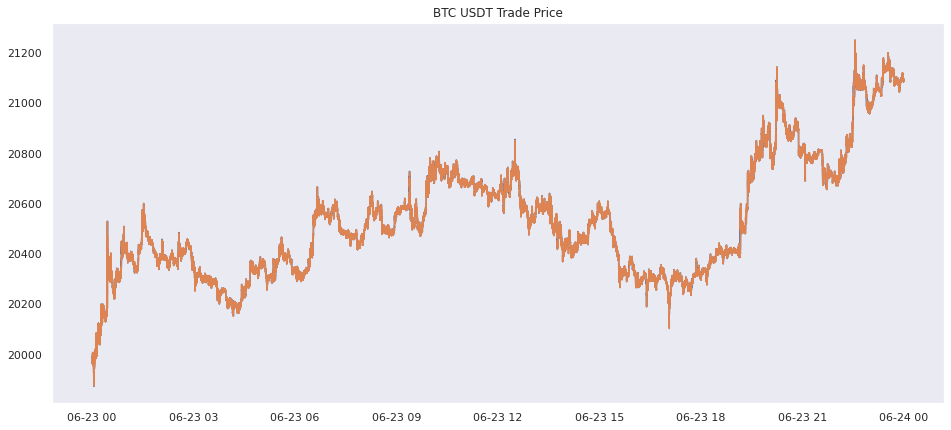

In [116]:
plt.figure(figsize=(16, 7))
plt.plot(agg_trades_bit['price_max'])
plt.plot(agg_trades_bit['price_min'])
plt.grid()
plt.title('BTC USDT Trade Price')
plt.show()

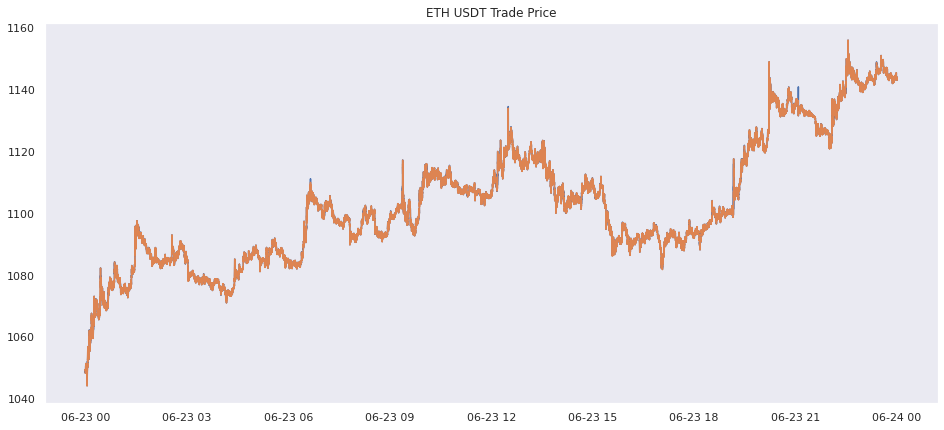

In [117]:
plt.figure(figsize=(16, 7))
plt.plot(agg_trades_eth['price_max'])
plt.plot(agg_trades_eth['price_min'])
plt.grid()
plt.title('ETH USDT Trade Price')
plt.show()

Более менее выровнилось

### 3. Пробитие стакана

In [119]:
delta_price_bit = agg_trades_bit['price_max'] - agg_trades_bit['price_min']

delta_price_eth = agg_trades_eth['price_max'] - agg_trades_eth['price_min']

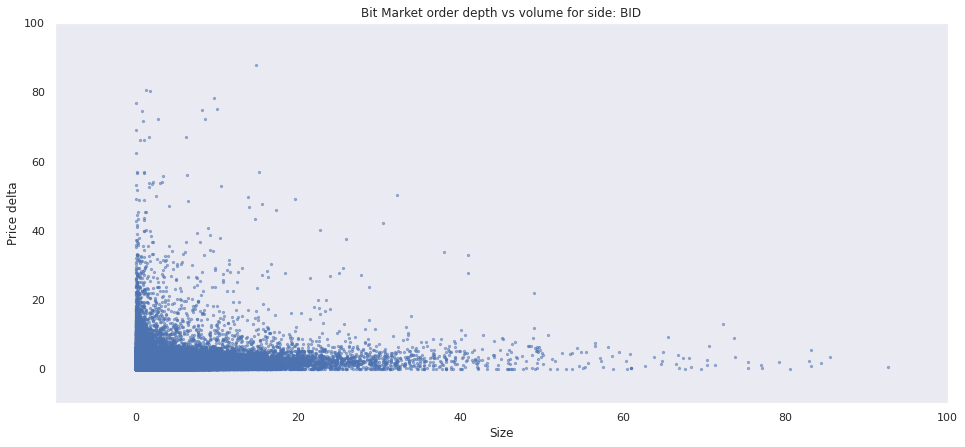

In [120]:
side = 'BID'
mask = agg_trades_bit['aggro_side_last'] == side

plt.figure(figsize=(16, 7))
plt.scatter(agg_trades_bit.loc[mask]['size_sum'], delta_price_bit.loc[mask], alpha=0.5, s=5)
plt.title(f'Bit Market order depth vs volume for side: {side}')
plt.xlabel('Size')
plt.ylabel('Price delta')
plt.xlim(-10, 100)
plt.ylim(-10, 100)
plt.grid()
plt.show()

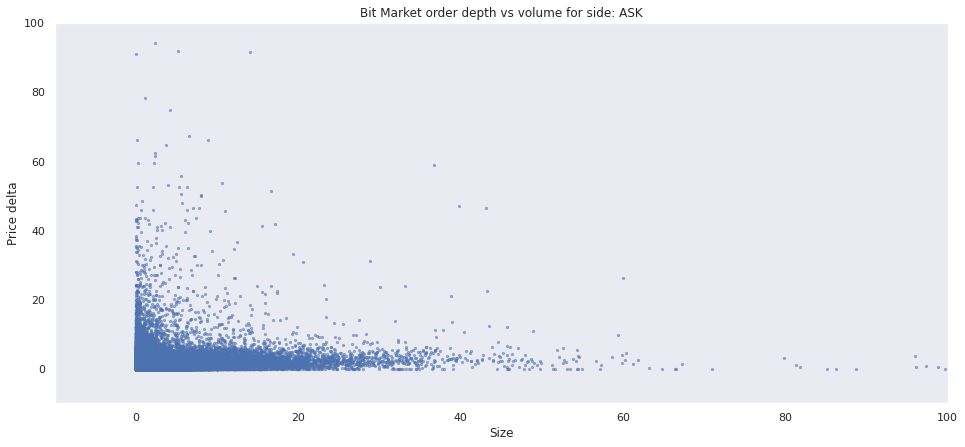

In [121]:
side = 'ASK'
mask = agg_trades_bit['aggro_side_last'] == side

plt.figure(figsize=(16, 7))
plt.scatter(agg_trades_bit.loc[mask]['size_sum'], delta_price_bit.loc[mask], alpha=0.5, s=5)
plt.title(f'Bit Market order depth vs volume for side: {side}')
plt.xlabel('Size')
plt.ylabel('Price delta')
plt.xlim(-10, 100)
plt.ylim(-10, 100)
plt.grid()
plt.show()

Чем меньше объем в стакане, тем проще пробить стакан глубже. Это логично, нужно пройти меньшее расстояние по объему трейда, что сдвинуть цену стакана. 

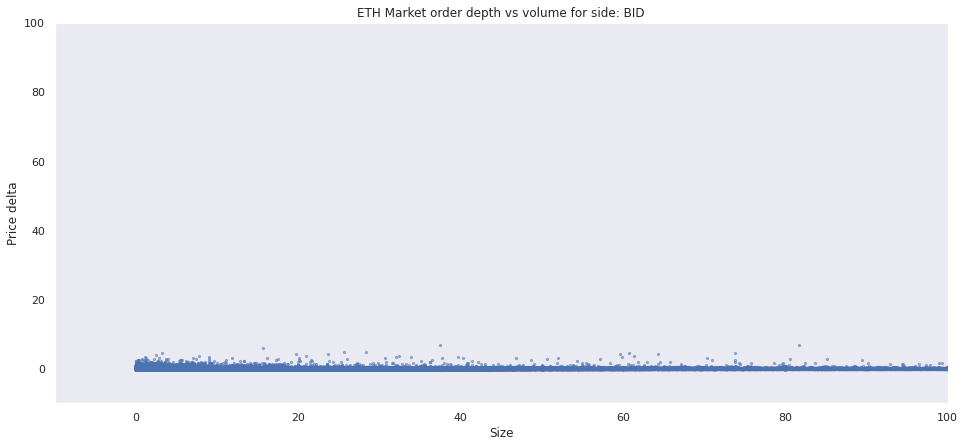

In [122]:
side = 'BID'
mask = agg_trades_eth['aggro_side_last'] == side

plt.figure(figsize=(16, 7))
plt.scatter(agg_trades_eth.loc[mask]['size_sum'], delta_price_eth.loc[mask], alpha=0.5, s=5)
plt.title(f'ETH Market order depth vs volume for side: {side}')
plt.xlabel('Size')
plt.ylabel('Price delta')
plt.xlim(-10, 100)
plt.ylim(-10, 100)
plt.grid()
plt.show()

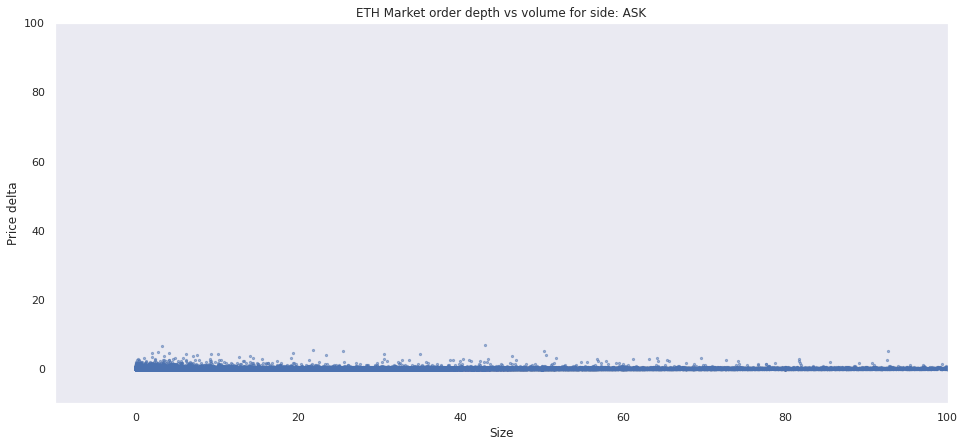

In [123]:
side = 'ASK'
mask = agg_trades_eth['aggro_side_last'] == side

plt.figure(figsize=(16, 7))
plt.scatter(agg_trades_eth.loc[mask]['size_sum'], delta_price_eth.loc[mask], alpha=0.5, s=5)
plt.title(f'ETH Market order depth vs volume for side: {side}')
plt.xlabel('Size')
plt.ylabel('Price delta')
plt.xlim(-10, 100)
plt.ylim(-10, 100)
plt.grid()
plt.show()

Можем сделать вывод, что биткоин более волатильный, чем эфир. 


